In [1]:
import sys, os
import sys, os
import json
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import ipywidgets as widgets
import plotly
import plotly.graph_objects as graph_obj
import plotly.figure_factory as ff

In [2]:
sys.path.append(os.path.join(os.getcwd(),'/app/utils'))
from s3 import s3store
from jsonutil import WriteDictJson, ReadDictJson

In [3]:
creds = ReadDictJson('../creds.json')
if not creds:
    output.append_stdout('Failed to load credentials file {}\n'.format(args.credentails))

s3def = creds['s3'][0]
s3 = s3store(s3def['address'], s3def['access key'], s3def['secret key'])
validation = s3def['sets']['trainingset']
s3def

{'name': 'mllib-s3', 'type': 'trainer', 'address': 'ipc.larson.myds.me:32000', 'access key': 'access', 'secret key': 'mysecretkey', 'sets': {'dataset': {'bucket': 'mllib', 'prefix': 'data', 'dataset_filter': ''}, 'trainingset': {'bucket': 'mllib', 'prefix': 'training', 'dataset_filter': ''}, 'model': {'bucket': 'mllib', 'prefix': 'model', 'dataset_filter': 'dl3'}, 'test': {'bucket': 'mllib', 'prefix': 'test', 'dataset_filter': ''}}}

In [4]:
test_obj = '{}/coco/tests.json'.format(validation['prefix'])
desc_obj = '{}/coco/description.json'.format(validation['prefix'])

In [5]:
testjson = s3.GetDict(validation['bucket'], test_obj)
descjson = s3.GetDict(validation['bucket'], desc_obj)


tests = pd.DataFrame(testjson)
display(tests)

,date,model,accuracy,class_similarity,similarity,confustion,images,image time,batch size,test store,test bucket,test object
0,"12/10/2020, 09:19:41",2020-12-03-05-52-45-cocoseg,0.869580,"{'0': {'intersection': 0, 'union': 0, 'similar...",0.634320,"[[842651, 2005, 1752, 17084], [30039, 53381, 2...",5,1.310252,1,ipc.larson.myds.me:32000,mllib,training/coco/2020-12-03-05-52-45-cocoseg/run....
1,"12/10/2020, 09:32:32",2020-12-03-05-52-45-cocoseg,0.933269,"{'0': {'intersection': 0, 'union': 0, 'similar...",0.599355,"[[1026475511, 6568840, 787060, 2550103], [2865...",5000,0.082757,1,ipc.larson.myds.me:32000,mllib,training/coco/2020-12-03-05-52-45-cocoseg/run....


In [8]:
test_names = []
for test in testjson:
    #print(test['model'])
    #print(test['date'])
    name = '{} {}'.format(test['model'], test['date'])
    test_names.append(name)

In [9]:
testjson

[{'date': '12/10/2020, 09:19:41', 'model': '2020-12-03-05-52-45-cocoseg', 'accuracy': 0.8695800185203553, 'class_similarity': {'0': {'intersection': 0, 'union': 0, 'similarity': 1.0}, '1': {'intersection': 53381, 'union': 90997, 'similarity': 0.5866237348484016}, '2': {'intersection': 114726, 'union': 192946, 'similarity': 0.5946015983746747}, '3': {'intersection': 82775, 'union': 111570, 'similarity': 0.7419109079501658}}, 'similarity': 0.6343204900976707, 'confustion': [[842651, 2005, 1752, 17084], [30039, 53381, 2614, 2691], [70012, 50, 114726, 3792], [5011, 217, 0, 82775]], 'images': 5, 'image time': 1.3102516, 'batch size': 1, 'test store': 'ipc.larson.myds.me:32000', 'test bucket': 'mllib', 'test object': 'training/coco/2020-12-03-05-52-45-cocoseg/run.json'}, {'date': '12/10/2020, 09:32:32', 'model': '2020-12-03-05-52-45-cocoseg', 'accuracy': 0.9332689494609833, 'class_similarity': {'0': {'intersection': 0, 'union': 0, 'similarity': 1.0}, '1': {'intersection': 72580710, 'union': 

In [10]:
iClasses = {}
classNames = [''] * descjson['classes']['classes']
for clasdesc in descjson['classes']['objects']:
    if clasdesc['trainId'] not in iClasses.keys():
        classNames[clasdesc['trainId']] = clasdesc['category']
        if not (clasdesc['category'] == 'void'):
            iClasses[clasdesc['trainId']] = clasdesc

iClasses 


{1: {'id': 1, 'name': 'person', 'trainId': 1, 'category': 'person', 'display': True, 'color': [0, 255, 0]}, 2: {'id': 2, 'name': 'bicycle', 'trainId': 2, 'category': 'vehicle', 'display': True, 'color': [255, 0, 0]}, 3: {'id': 16, 'name': 'bird', 'trainId': 3, 'category': 'animal', 'display': True, 'color': [0, 0, 255]}}

In [11]:
overview = {}
results = {}
confusion = {}
for test in testjson:
    
    test_overview = {'accuracy':test['accuracy'],'similarity':test['similarity']}
    overview[test['model']]=test_overview
    
    similarity = {}
    for key in iClasses:
        res = test['class_similarity'][str(key)]
        if res:
            print('Key {} {}'.format(key, iClasses[key]['category']))
            print('{}'.format(test['class_similarity'][str(key)]['similarity']))
            similarity[iClasses[key]['category']] = test['class_similarity'][str(key)]['similarity']

    results[test['model']] = similarity
    
    confustion_array = np.array(test['confustion'])
    confustion_array = confustion_array / confustion_array.astype(np.float).sum(axis=1)
    confusion[test['model']]=test['confustion']


Key 1 person
0.5866237348484016
Key 2 vehicle
0.5946015983746747
Key 3 animal
0.7419109079501658


TypeError: unsupported operand type(s) for /: 'int' and 'function'

In [125]:
display(pd.DataFrame(overview).T)

,accuracy,similarity
2020-12-03-05-52-45-cocoseg,0.933269,0.599355


In [60]:
display(pd.DataFrame(results).T)

,animal,person,vehicle
2020-12-03-05-52-45-cocoseg,0.634077,0.660616,0.421456


In [136]:
def SelectTest(change, select, testjson):
    print("SelectTest")

In [137]:
def ClearOutput(b):
    output.clear_output()

In [139]:
output = widgets.Output()
clear_output = widgets.Button(description='Clear Output')


clear_output.on_click(lambda b: ClearOutput(b))

test_select = widgets.Select(
    options=[],
    description='Test:',
    disabled=False,
    #rows=25,
)

attach = widgets.VBox([test_select, clear_output, output])

test_select.observe (lambda change:SelectTest(change, select=test_select, testjson=testjson), names="value")

if len(test_names) > 0:
    test_select.options = test_names
    test_select.value = test_names[0]

display(attach)

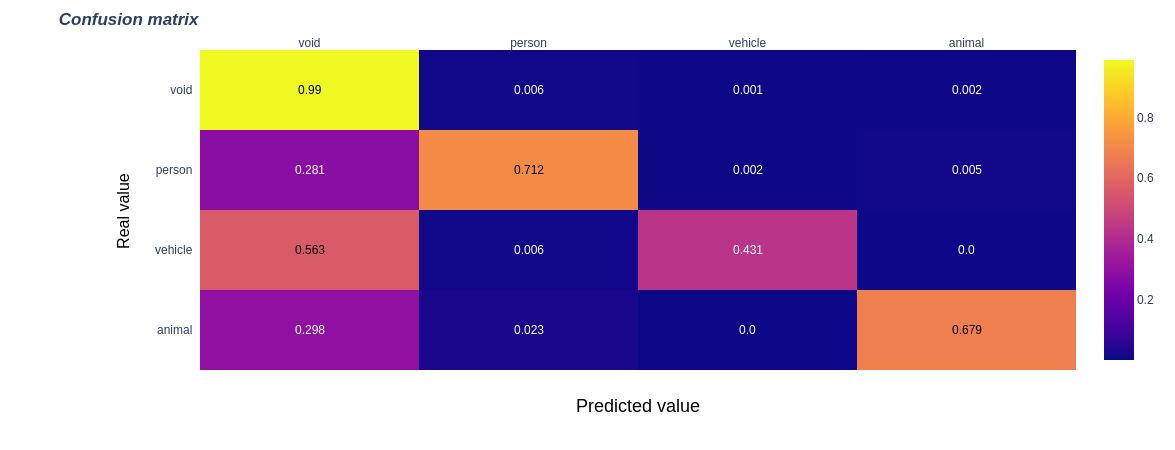

In [124]:
# change each element of z to type string for annotations
c = np.array(confusion['2020-12-03-05-52-45-cocoseg'])
norm_confusion = (c.T / c.astype(np.float).sum(axis=1)).T

confusion_text = [[str(round(y, 3)) for y in x] for x in norm_confusion]

# set up figure 

fig = plotly.figure_factory.create_annotated_heatmap(norm_confusion, x=classNames, y=classNames, annotation_text=confusion_text, colorscale='plasma')
# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>')

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=16),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=16),
                        x=-0.1,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.update_layout(yaxis_autorange="reversed")
fig.show()